In [24]:
import nbimporter
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import math

from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid


import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

In [101]:
def graphSelectionRates(selected, candidates, protectedClass):
    selected_candidates = selected.copy()
    candidates_all = candidates.copy()
    raceIndxs = {"Caucasian": 0, "African-American": 1, "Asian": 2, "Hispanic": 3, "Other": 4 }
    sexIndxs = {"Male":0, "Female":1}
    
    if protectedClass == "race":
        features = [col for col in selected_candidates if col.startswith("race_")]
        race_selected = selected_candidates[features].idxmax(axis=1).str.replace('race_', '')
        race_all = candidates_all[features].idxmax(axis=1).str.replace('race_', '')
        
        candidates_all["Race"] = race_all
        selected_candidates["Race"] = race_selected

        numCandidates = candidates_all["Race"].value_counts()
        numQualified = selected_candidates["Race"].value_counts()

        selectionRate1 = numQualified["Caucasian"] / numCandidates["Caucasian"]
        selectionRate2 = numQualified["Asian"] / numCandidates["Asian"]
        selectionRate3 = numQualified["African-American"] / numCandidates["African-American"]
        selectionRate4 = numQualified["Hispanic"] / numCandidates["Hispanic"]
        
        print("The selection rate for " + "Caucasian" + "s: ",selectionRate1)
        print("The selection rate for " + "Asian" + "s: ", selectionRate2)
        print("The selection rate for " + "African-American" + "s: ",selectionRate3)
        print("The selection rate for " + "Hispanic" + "s: ",selectionRate4)
        
        y_pos = np.arange(4)
        performance = [selectionRate1, selectionRate2, selectionRate3, selectionRate4]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Caucasian", "Asian", "African-American", "Hispanic"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Race')
        plt.show()
    elif protectedClass == "gender":
        
        features = [col for col in selected_candidates if col.startswith("gender_")]
        gender_selected = selected_candidates[features].idxmax(axis=1).str.replace('gender_', '')
        gender_all = candidates_all[features].idxmax(axis=1).str.replace('gender_', '')

        candidates_all["Gender"] = gender_all
        selected_candidates["Gender"] = gender_selected
        
        numCandidates = candidates_all["Gender"].value_counts()
        numQualified = selected_candidates["Gender"].value_counts()
        
        print(numCandidates)
        print(numQualified) 
        
        maleSelectionRate = numQualified["male"] / numCandidates["male"]
        femaleSelectionRate = numQualified["female"] / numCandidates["female"]
        print("The selection rate for " + "Male" + "s: ", maleSelectionRate)
        print("The selection rate for " + "Female" + "s: ", femaleSelectionRate)
        y_pos = np.arange(2)
        performance = [maleSelectionRate, femaleSelectionRate]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Male", "Female"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Sex')
        plt.show()
    else:
        print("Try another protected type - gender or race")
        
        
def getOnehottedDataset(dataset, features, prefixes):
# race, sex, sports, birth origin, education, educational prestige, criminal record, arrest record,
    onehotted_data = dataset.copy()
    onehotted_data = pd.get_dummies(onehotted_data, columns=features, prefix=prefixes)
    return onehotted_data
       
def classificationSelection(candidates, labels, acceptValue):
    df = candidates.copy()
    df["Labels"] = labels
    candidatesSelected = df[df["Labels"].isin([acceptValue])]
    return candidatesSelected

def transformDatapointsToScale(dataset, selectedFeatures):
    df = dataset.copy()
    for feature in selectedFeatures:
        maximum = df[feature].max()
        df[feature] = df[feature].apply(lambda x: x / maximum)
    return df

In [109]:
##################################
# Label Assignment Options #######
# Run Cell to Initialize Methods #
##################################

# Generates labels by ranking by the passed in metric, then dividing into terciles.
def assignLabelsByTerciles(dataset, metric):
    df = dataset.copy()
    if percentiles == "thirds":
        df = df.sort_values([metric], ascending=False)
        labels = []
        for x in range(len(dataset)):
            if x < len(dataset) / 3:
                labels.append(1)
            elif x < len(dataset) / 3 * 2:
                labels.append(0)
            else:
                labels.append(-1)
        df["Label"] = labels
        #  Need to shuffle because just ranked them by deal count or whatever the metric is...
        df = df.sample(frac=1).reset_index(drop=True)
    else: 
        print("Invalid percentile requested to create labels by ")
    return dataset

# Generates labels by ranking by the passed in metric, then dividing into quintiles.
def assignLabelsByQuintiles(employees, metric):
    employees_labelled = employees.copy()
    employees_labelled = employees_labelled.sort_values([metric], ascending=False)
    fifth = math.floor(len(employees_labelled) / 5)
    num = 2
    labels = []
    for x in range(5):
        for y in range(fifth):
            labels.append(num)
        num -= 1
    employees_labelled["Label"] = labels
    employees_labelled = employees_labelled.sample(frac=1).reset_index(drop=True)
    return employees_labelled

def assignLabelsByPercentile(employees, metric, percentile):
    employees_labelled = employees.copy()
    employees_labelled = employees_labelled.sort_values([metric], ascending=False)
    nths = math.floor(len(employees_labelled) / percentile)
    num = percentile - 1
    labels = []
    for x in range(percentile):
        for y in range(nths):
            labels.append(num)
        num -= 1
    while (len(labels) != len(employees)):
        labels.append(np.random.choice(percentile))
    employees_labelled["Label"] = labels
    
    employees_labelled = employees_labelled.sample(frac=1).reset_index(drop=True)
    return employees_labelled 


# Generates labels by ranking by the passed in metric, then dividing into quintiles.
def discretize(vector, range):
    newRange = range
    vals = [range]
    x = True
    while(x):
        range -= 1
        if abs(range) <= newRange:
            vals.append(range)
        else:
            x=False
    roundedVals = []
    for x in vector:
        newVal = int(x)
        if abs(newVal) > newRange:
            # if greater than the newRange:
            if newVal < 0:
                newVal = -1*newRange
            else:
                newVal = 1*newRange
        roundedVals.append(newVal)
    return roundedVals

# Milestone 2: 

## Exercise 2:

Ok, so in this exercise your team is going to get an introduction to classifiers!

- So in the last exercise we implemented a linear regression algorithm and used the results to rank individuals then select them based on a percentile cutoff. We attempted to analyze performance through conventional metrics like R^2 and MSE but also considered this notion of differential validity. Another way we may seek to try and select candidates is through a classification approach similar to what we did in the nearest neighbors model in the first milestone. 
- In this task we'll ask you to go ahead and run the model, then analyze its results through a series of performance and fairness metrics.  
- Finally we'll ask you to consider deficiencies in the approach and from where these deficiencies likely arise.
- Then your team can optionally iterate to tweak various aspects of the model though you will get the opportunity to do this at length in the final exercise.


## A Classification Approach through k Nearest Neighbors

Recall that in the nearest neighbor algorithm in Milestone 1, we found the one employee that had the smallest "distance" to the candidate in terms of the selected features' values.  Then whatever label the employee had was the one we assigned to the candidate. kNN is a generalization of that. We basically say, hey look, instead of just looking at the single closest employees, lets look at the 3/4/5 closest ones and see what labels they have. Then of those 3/4/5 labels, whichever label is most common is the one we assign to the candidate. 

For example if k = 4, then we look at the 4 "nearest" employees to candidate X. If 3 of the 4 nearest employees to candidate X have a label of "Excellent" then we predict that the employee will be "Excellent".  This is supposed to be far more robust than nearest neighbor where k=1, because it avoids the scenario where the single closest employee is perhaps an outlier, therefore assigning an incorrect label to candidate X. Note that the nearest neighbor model is just kNN but that k = 1!

For this first part of the task we've already selected and scaled the features for you for the sake of
convenience. Based on your understanding of the dataset and its features, please do consider what potential issues may arise from the features that we have chosen to select.

### Subtask: Warmup (OPTIONAL):
- You should have already familiarized yourself with the dataset in the last exercise but feel free to use the code below to analyze the dataset again. You can use it to plot a particular feature's values in the dataset against the performance colored by protected group.
- If you want to study other aspects of the dataset feel free to look back to exercise 1 of the milestone and copy over some of those methods to the cell block below for use!

In [57]:
# Loading the dataset
employees = pd.read_csv("../Employees_M2/employees_milestone2.csv")
candidates = pd.read_csv("../Candidates_M2/candidates_milestone2.csv")
# employeeData.info()

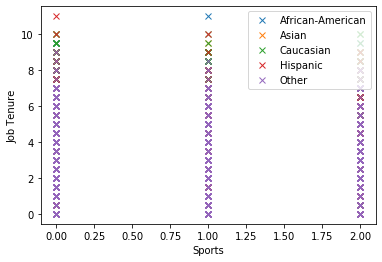

In [86]:
##########################
# DATASET ANALYSIS TOOLS #
##########################

def plotFeatureToPerformance(dataset, feature, metric, protectedClass, val=None):
    
    df = dataset.copy()
    if val != None:
        if len(val) == 1:
            df = df.loc[(df[protectedClass] == val[0])]
        elif len(val) == 2:
            df = df.loc[(df[protectedClass]== val[0]) | (df[protectedClass]== val[1])]

    df = df[[feature, metric, protectedClass]]

    groups = df.groupby(protectedClass)

    for name, group in groups:
        plt.plot(group[feature], group[metric], marker="x", linestyle="", label=name)
        
    plt.xlabel(feature)
    plt.ylabel(metric)
    plt.legend()
    
feature = "Sports"# INSERT A FEATURE #
metric = "Job Tenure"# SELECT A METRIC #
protectedClass =  "Race"# INSERT A PROTECTED CLASS # 
plotFeatureToPerformance(employees, feature, metric, protectedClass)
# plotFeatureToPerformance(candidates, feature, metric, protectedClass) 

### Subtask: Data Pre-processing & Prepation

In [58]:
# RUN THIS CELL (0 Lines) #
# One-hotting the dataset for use #
features = ["Race", "Gender", "Birth Origin", "Criminal Record", "Sports",
           "Arrest Record", "LinkedIn Score", "Responsible Social Media Use", "Undergraduate Degree", "Employee Referral"]
prefixes = ["race", "gender", "origin", "criminal", "sports", "arrest", "linkedin", 
           "socmedia", "degree", "referral"]
employees_race = employees["Race"]
candidates_race = candidates["Race"]
employees_processed = getOnehottedDataset(employees, features, prefixes)
employees_processed["Race"] = employees_race
candidates_processed = getOnehottedDataset(candidates, features, prefixes)
candidates_processed["Race"] = candidates_race
employees_processed.info()
# RUN THIS CELL #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Names                       10000 non-null  object 
 1   Age                         10000 non-null  float64
 2   Zip                         10000 non-null  int64  
 3   Education                   10000 non-null  int64  
 4   GPA                         10000 non-null  float64
 5   Educational Prestige        10000 non-null  float64
 6   Years of Experience         10000 non-null  float64
 7   Soft Skills                 10000 non-null  float64
 8   Manager's Assessment Score  10000 non-null  float64
 9   Military Tenure             10000 non-null  float64
 10  Avg Commute Time            10000 non-null  float64
 11  Job Tenure                  10000 non-null  float64
 12  Cultural Fit                10000 non-null  float64
 13  Leadership Capability       1000

In [92]:
# RUN THIS CELL (0 Lines) #
selectedFeatures = [
    "Cultural Fit", "HireVue Score", "sports_2.0"
]

metric = "Job Tenure"
# RUN THIS CELL #

Ok we've selected features to use and a metric for you to experiment with the model. Your team will have the chance to improve it in just a bit.

Recall that the former regression algorithm's utilization of the "Manager's Assessment Score" made a lot of sense because the Assesment score was a continuous value. Linear Regression was thus a great first choice. But now with classification, we need to have labels, or categories that we are trying to get our model to learn how to predict based on the sample's input. In order to do this, similar to the methods we used in Milestone 1 Exercise 3, we'll artificially generate labels by dividing the samples into quintiles based on their manager's assessment score. 

Your team will get to choose your own method of label generation in future parts!

In [120]:
# RUN THIS CELL (0 Lines) #
# Used as a sanity check for the label generation - features that are predictive should have a meaningful difference in their
# mean, median, and/or variance, across distinct label groups.

# @params: the dataset, the metric you want to generate labels for, and a feature of interest
# @return: prints out the mean and median values per feature per label value of the dataset
# of each label value

def printStats(employees, label, features):
    df = employees.copy()
    
    label_vals = df[label].unique()
    label_vals.sort()
    
    for feature in features:
        for label_val in label_vals:
            
            selectedFeature = df.loc[(df[label] == label_val)][feature]
            print("The mean of " + feature + " for employees with " + str(label_val) + " is", selectedFeature.mean())
            print("The median of " + feature + " for employees with " + str(label_val) + " is", selectedFeature.median())
            print("")
                       
employees_processed = assignLabelsByPercentile(employees_processed, metric, 10)
printStats(employees_processed, "Label", selectedFeatures)
# RUN THIS CELL (0 Lines) #

The mean of Cultural Fit for employees with 0 is -3.1747499999999986
The median of Cultural Fit for employees with 0 is -2.97

The mean of Cultural Fit for employees with 1 is -2.023910000000001
The median of Cultural Fit for employees with 1 is -1.92

The mean of Cultural Fit for employees with 2 is -1.2358099999999994
The median of Cultural Fit for employees with 2 is -1.23

The mean of Cultural Fit for employees with 3 is -0.7527099999999989
The median of Cultural Fit for employees with 3 is -0.77

The mean of Cultural Fit for employees with 4 is -0.17924000000000015
The median of Cultural Fit for employees with 4 is -0.185

The mean of Cultural Fit for employees with 5 is 0.10496000000000004
The median of Cultural Fit for employees with 5 is 0.09999999999999999

The mean of Cultural Fit for employees with 6 is 0.68835
The median of Cultural Fit for employees with 6 is 0.71

The mean of Cultural Fit for employees with 7 is 1.1681600000000005
The median of Cultural Fit for employees 

#### Normalization & Train-Test Split

In [121]:
# RUN THIS CELL (0 Lines) #
employees_scaled = employees_processed  # No normalization, will use MinMaxScaler

y = employees_scaled["Label"]
X = employees_scaled.drop(["Label"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

X_train_selectedFeatures = X_train[selectedFeatures].copy()
X_test_selectedFeatures = X_test[selectedFeatures].copy()

def rescaling(X):
#     print(X)
    scaler = MinMaxScaler()
    scaler.fit(X)
    data = scaler.transform(X)
    return data

X_scaled_train = rescaling(X_train_selectedFeatures)
# RUN THIS CELL (0 Lines) #

### Subtask: Model Training & Initial Performance

Great! So its time to train the model and evaluate its performance on the train and test sets. In classification the performance metrics are actually way more intuitive than what we came across in regression analysis. That's because since we're predicting a label as opposed to a continuous score, we can use common-sense notions like accuracy to evaluate our model. 

However, in addition to accuracy we also want to introduce you to two new concepts, Precision and Recall. These are two additional measures used in classification task to measure the relative ratio of false positives and the relate ratio of false negatives. 

A false positive, in our case would be labelling an unqualified candidate as qualified.
A false negative, would be labelling an qualified candidate as unqualified.  

Note that based on our labelGeneration and subsequent determinations, qualified and unqualified are still up to us.
On the extremes we can label every qualified, so we'd have zero false negatives or we can label everyone as unqualified so we have zero false positives.

To formalize our performance metrics we have the following!
    - Accuracy = TP + TN / TP + TN + FN + FP
    - Precision = TP / TP + FP.
    - Recall = TP / TP + FN. 

In [122]:
# RUN THIS CELL (0 Lines) #
# Trains the model
neigh = KNeighborsClassifier(n_neighbors=4, metric="minkowski", p=3)
knn_model = neigh.fit(X_scaled_train, y_train)
# RUN THIS CELL #

In [123]:
# RUN THIS CELL (0 Lines) #
# Passed-in model predicts on X. Resultant, accuracy
# more intuitive performance metrics like accuracy, precision, and recall on X is printed.
# @params fitted model => model, dataset of candidates with selectedFeatures => X, labels of X candidates.
def getModelStats(model, X, y):
    y_pred = model.predict(X)
    vals = {}
    for x in range(len(y_pred)):
        if y_pred[x] not in vals:
            vals.update({y_pred[x]: 1})
        else: 
            vals[y_pred[x]] += 1
    print(vals)
    
    print("The accuracy of our model on the data is: ", accuracy_score(y_pred, y))
    print("The precision of our model on the data is: ", precision_score(y_pred, y, average='macro'))
    print("The recall of our model on the data is: ", recall_score(y_pred, y, average='macro'))
    # print("The f1 score of our model on the data is: ", f1_score(y_pred, y, average='macro'))

    
# Evaluates model performance
getModelStats(knn_model, X_scaled_train, y_train)
# RUN THIS CELL #

{4: 827, 0: 836, 8: 707, 2: 741, 7: 695, 9: 689, 3: 717, 1: 771, 5: 712, 6: 805}
The accuracy of our model on the data is:  0.6986666666666667
The precision of our model on the data is:  0.6989769903547233
The recall of our model on the data is:  0.699170275894405


### Subtask: Analyzing Fairness

In the last exercise, we analyzed fairness through the lens of differential validity and selection rates, or disparate impact. But because we are not in the realm of classification as opposed to regression we have more ways in which we can evaluate the fairness of our algorithm.  The driving concepts behind the fairness concepts we'll review here are in balancing certain rates.

#### Part A: 
We might want to check these metrics for a certain protected group. We can do this using the function select persons in class. See the example usage below!

In [124]:
# RUN THIS CELL (1 Line) #
# Takes the dataset and returns all members in the dataset whose protectedClass is of the value
# For example, if protectedClass=race and value="African-American", returns all African-Americans in the dataset.
def selectPersonsInClass(data, protectedClass, value):
    df = data.loc[(data[protectedClass] == value)]
    print("Num of rows of ppl who are %s:"% (value ,), len(df))
    return df

x_class = selectPersonsInClass(employees_scaled, "Race", "Other") # Examine per protectedClass! #
y_class = x_class["Label"]
x_class_selectedFeatures = rescaling(x_class[selectedFeatures].copy())
getModelStats(knn_model, x_class_selectedFeatures, y_class)
# RUN THIS CELL (1 Lines) #

Num of rows of ppl who are Other: 600
{2: 49, 9: 95, 0: 84, 4: 46, 6: 57, 5: 49, 7: 49, 8: 73, 1: 56, 3: 42}
The accuracy of our model on the data is:  0.5166666666666667
The precision of our model on the data is:  0.5146094324065474
The recall of our model on the data is:  0.50025077637086


##### Question: 
- In the context of hiring, discuss with your team what you believe is worse, a poor Recall, or a poor Precision?
- What context might be helpful to have in answering that question? 

#### Part B: 
In addition to examining the distinct accuracy, precision, and recall among different groups. Some additional fairness metrics can be utilized.  We might wonder if the false positive and false negative rates are balanced among the groups.  We can calculate this by having our "fitted" model make predictions on the employees in our dataset, and printing out a confusion matrix.

A confusion matrix is a helpful tool in analyzing a classification algorithm's performance. It enumerates the number of True Positives, True Negatives, False Positives, False Negatives in the model's predictions. By doing so we can calculate the following useful metrics below among each class.

- False Positive Rate = False Positives / False Positives + True Negative
- False Negative Rate = False Negatives / False Negative + True Positive

As an interesting aside here, in addition to another well-known fairness metric named calibration, or statistical parity. It has been shown that one could not simultaneously satisfy calibration, a balanced false positivity, and a balanced false negative rate so long as there was a disproportionate balance in the distribution of groups.

In [125]:
def getRates(model, x, y):
    y_true = y
    y_prediction = model.predict(x)
    cnf_matrix = confusion_matrix(y_true, y_prediction)
    
    uniq_values = np.unique(y_true)
    
    print("This is the confusion matrix for the inputted datapoints")
    labelled_matrix = pd.crosstab(y_true, y_prediction, rownames=['True'], colnames=['Predicted'], margins=True)
    print(labelled_matrix)
    #[[1 1 3]
    # [3 2 2]
    # [1 3 1]]
    print("")

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
#     TPR = TP/(TP+FN)
    # Specificity or true negative rate
#     TNR = TN/(TN+FP) 
#     Precision or positive predictive value
#     PPV = TP/(TP+FP)
    # Negative predictive value
#     NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print("The false positive rate for each label is the following: ")
    fprs = {uniq_values[x]: FPR[x] for x in range(len(uniq_values))}
    print(fprs)
    # False negative rate
    FNR = FN/(TP+FN)
    print("The false negative rate for each label is the following: ")
    fnrs = {uniq_values[x]: FNR[x] for x in range(len(uniq_values))}
    print(fnrs)
    # False discovery rate
#     FDR = FP/(TP+FP)
    # Overall accuracy
#     ACC = (TP+TN)/(TP+FP+FN+TN)

# RUN THIS CELL (1 Line) #
x_class = selectPersonsInClass(employees_scaled, "Race", "African-American") # Examine per protectedClass! #
y_class = x_class["Label"]
x_class_selectedFeatures = rescaling(x_class[selectedFeatures].copy()) # Don't forget to re-scale!
getRates(knn_model, x_class_selectedFeatures, y_class)
# RUN THIS CELL (1 Lines) #

Num of rows of ppl who are African-American: 1400
This is the confusion matrix for the inputted datapoints
Predicted    0    1    2    3    4    5    6    7   8   9   All
True                                                           
0          127    9    0    0    0    0    0    0   0   0   136
1           35   84   19    0    0    0    0    0   0   0   138
2            0   33   72   35    1    0    0    0   0   0   141
3            0    2   40   67   22    8    0    0   0   0   139
4            0    0    7   47   76   23    0    0   0   0   153
5            0    0    3   21   67   42    5    0   0   0   138
6            0    0    0    2   35   53   42    7   0   0   139
7            0    0    0    0   16   18   57   45   8   0   144
8            0    0    0    0    0    2   25   60  46   3   136
9            0    0    0    0    0    0    0    4  45  87   136
All        162  128  141  172  217  146  129  116  99  90  1400

The false positive rate for each label is the following: 
{0

#### Question:
- In the context of statutory liability, can these metrics be relevant?
- How might you be able to use these metrics in litigation as Counsel to the EEOC? Or how might you use them as Counsel to Sprawlmart?

### Subtask: Deploying to Production on our Candidates

Ok, you've successfully run through the models and examined base levels of performance from a standpoint of a variety of metrics. You're well on your way to becoming a lawyer data-scientist! You should also have an intuition for how the general pipeline of model development might go in a generality.

However, after model tweaking and testing on our inital train and test sets, it's time to actually deploy this trained model on our 500 or so candidates. Note that since these are not employees we don't actually have the key "ground-truth" metrics that we were using to create labels for our models to try and predict.  The point is that we have developed a model with features that all the candidates have and we make our prediction ("assign a label") based on a relative total distance measure (in the case of kNN)

One problem is that we again have to develop some sort of selection criteria.  Should we bring in the top two quintiles, just the top quintile? If we're using different labels, then we might need to change that selection strategy. This is what constitutes the "hiring" in our algorithm.

In this case we've decided to divide our employees into 6 labels by "sixth-tiles", we'll select the candidates that get assigned the top "sixth" label.

The selection rate for Caucasians:  0.24581818181818182
The selection rate for Asians:  0.24266666666666667
The selection rate for African-Americans:  0.17714285714285713
The selection rate for Hispanics:  0.14


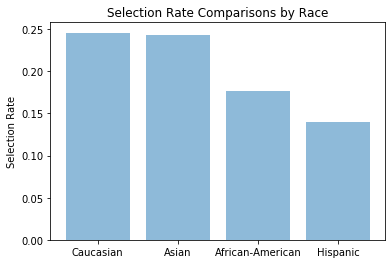

In [126]:
# RUN THIS CELL (0 Lines) #
# Ok, lets run it on the candidate dataset!
# X_candidates = candidates_processed[selectedFeatures].copy()
x_candidates = rescaling(candidates_processed[selectedFeatures].copy())
candidate_labels = knn_model.predict(x_candidates)

candidatesSelected = classificationSelection(candidates_processed, candidate_labels, 9)

graphSelectionRates(candidatesSelected, candidates_processed, "race")
# RUN THIS CELL (0 Lines) #

#### Guiding Questions:
- Is there a disparate impact? If there is, what do you believe in the dataset or algorithm is causing that bias?
- Would a business necessity defense be sufficient to justify the bias?
- How would you attempt to improve the approach?
- Are there particular race-aware corrections that could be utilized here to mitigate the bias?